In [1]:
import tensorflow as tf 
import keras_cv
from tensorflow import keras 
from keras import layers, Input

  
import numpy as np 
import matplotlib.pyplot as plt 
  


# Load in the data 
cifar100 = tf.keras.datasets.cifar100 

# Distribute it to train and test set 
(x_train, y_train), (x_test, y_test) = cifar100.load_data() 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 


2024-05-03 14:02:16.569712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 14:02:16.569812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 14:02:16.692229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [ ]:
model = tf.keras.models.Sequential([ 
layers.Conv2D(16, (3, 3), activation='gelu',input_shape=(32, 32, 3), padding='same'), 
layers.MaxPooling2D(2, 2), 
layers.Conv2D(32, (3, 3),activation='gelu', padding='same'), 
layers.MaxPooling2D(2, 2), 
layers.Conv2D(64, (3, 3), activation='gelu', padding='same'), 
layers.MaxPooling2D(2, 2), 
layers.Conv2D(128, (3, 3), activation='gelu', padding='same'), 


layers.Flatten(), 
layers.Dense(256, activation='gelu'), 
layers.BatchNormalization(), 
layers.Dense(256, activation='gelu'), 
layers.Dropout(0.3), 
layers.BatchNormalization(), 
layers.Dense(100, activation='gelu') 
]) 

model.summary()

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, AveragePooling2D
from tensorflow.keras.layers import Add, DepthwiseConv2D, Resizing
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

def inverted_residual_block(x, lf, expand=64, squeeze=16):
  m = Conv2D(expand, (1,1), activation='gelu', padding= "same")(x)
  m = DepthwiseConv2D(lf, activation='gelu', padding= "same")(m)
  m = Conv2D(squeeze, (1,1), activation='gelu', padding= "same")(m)
  return Add()([m, x])

input_img = Input(shape=(32,32,3))

#shortcut 1
x_short1 = Conv2D(32, kernel_size=(3,3), padding= "same", activation='gelu')(input_img)
x_short1 = Resizing(8, 8, interpolation="bilinear", crop_to_aspect_ratio=True)(x_short1)

x = layers.Conv2D(16, (3, 3), activation='gelu',input_shape=(32, 32, 3), padding='same')(input_img)
x = inverted_residual_block(x, (3,3), expand=64, squeeze=16) #mobilenet layer
x = layers.MaxPooling2D(2, 2)(x)
x = layers.Conv2D(32, (3, 3),activation='gelu', padding='same')(x) 
x = inverted_residual_block(x, (3,3), expand=64, squeeze=32) #mobilenet layer
x = layers.MaxPooling2D(2, 2)(x)

x = Add()([x, x_short1])

x = layers.Conv2D(64, (3, 3), activation='gelu', padding='same')(x)
x = inverted_residual_block(x, (3,3), expand=128, squeeze=64) #mobilenet layer
x = layers.MaxPooling2D(2, 2)(x)

#shortcut 2
x_short2 = Conv2D(128, kernel_size=(3,3), padding= "same", activation='gelu')(input_img)
x_short2 = Resizing(4, 4, interpolation="bilinear", crop_to_aspect_ratio=True)(x_short2)

x = layers.Conv2D(128, (3, 3), activation='gelu', padding='same')(x) 
x = inverted_residual_block(x, (3,3), expand=192, squeeze=128) #mobilenet layer

x = Add()([x, x_short2])

x = layers.Conv2D(128, (3, 3), activation='gelu', padding='same')(x) 
x = inverted_residual_block(x, (3,3), expand=192, squeeze=128) #mobilenet layer

x = layers.Flatten()(x) 
x = layers.Dense(256, activation='gelu')(x) 
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='gelu')(x) 
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(100, activation='gelu')(x)


model = Model(inputs=input_img, outputs=[output])
model.summary()

In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# number of classes
nb_classes = len(np.unique(y_train))

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

x_train =(x_train)/255.0
x_test = (x_test)/255.0


train_datagen = ImageDataGenerator(
    rotation_range=30,
    #zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #vertical_flip=True
)

val_datagen = ImageDataGenerator()

it = train_datagen.flow(x_train, y_train, shuffle=True)
iv = val_datagen.flow(x_test, y_test, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print (np.max(x_train), np.min(x_train))


(50000, 32, 32, 3)
(50000, 100)
1.0 0.0


In [ ]:
print (np.max(x_train), np.min(x_train))

In [3]:
from tensorflow.keras.models import Model
import tensorflow_hub as hub
from keras.layers import Input, Dense, Dropout, Flatten

model_eff = keras_cv.models.EfficientNetV2Backbone.from_preset(
   "efficientnetv2_s_imagenet",#"efficientnetv2_b2_imagenet",
    input_shape=(32, 32, 3),
    #input_tensor=input_img,
    load_weights=True,
)

model_yolo8 = keras_cv.models.YOLOV8Backbone.from_preset(
   "yolo_v8_l_backbone",
    input_shape=(32, 32, 3),
)

model_csp = keras_cv.models.CSPDarkNetBackbone.from_preset(
   "csp_darknet_l_imagenet",
    input_shape=(32, 32, 3),
    load_weights=True,
)

#model_eff.trainable = False


#input_img = Input(shape=(32,32,3))
#x = model_yolo8(input_img)
#x = model_csp(input_img)
x = model_eff.output
#x = model_convnext(input_img)
#x = layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(512, activation='swish')(x) 
x = keras.layers.GaussianDropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(100, activation='softmax')(x)

model = Model(inputs=model_eff.input, outputs=output)

#model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_s_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_l_backbone/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/yolov8/keras/yolo_v8_l_backbone/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/cspdarknet/keras/csp_darknet_l_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/cspdarknet/keras/csp_darknet_l_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/cspdarknet/keras/csp_darknet_l_imagenet/2' to your Kaggle notebook...


In [4]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-7)

model.compile( 
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1), 
optimizer= keras.optimizers.Adam(learning_rate=1e-3),
#optimizer= keras.optimizers.Lion(learning_rate=1e-3),
metrics=['accuracy']
) 

hist = model.fit(it,
                 epochs=50, 
                 batch_size=128, 
                 verbose=1,
                 callbacks=[reduce_lr],
                 validation_data=(iv))

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714745196.072168      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 473s 165ms/step - accuracy: 0.1137 - loss: 4.2742 - val_accuracy: 0.3466 - val_loss: 2.9495 - learning_rate: 0.0010
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.2926 - loss: 3.1572 - val_accuracy: 0.4178 - val_loss: 2.6597 - learning_rate: 0.0010
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.3521 - loss: 2.8935 - val_accuracy: 0.4628 - val_loss: 2.5004 - learning_rate: 0.0010
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.4007 - loss: 2.7292 - val_accuracy: 0.4926 - val_loss: 2.3873 - learning_rate: 0.0010
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.4137 - loss: 2.6940 - val_accuracy: 0.4569 - val_loss: 2.5241 - learning_rate: 0.0010
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.3986 - loss: 2.7444 - val_accuracy: 0.4742 - val_loss: 2.4768 - learning_rate: 0.0010
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 92s 59ms/step - accuracy: 0.424

In [5]:
# Save the model in native Keras format
model.save('model_effnetv2.keras')


In [5]:
import numpy as np
from sklearn.metrics import classification_report
import time 


# Evaluate the model on the test data
start_time = time.time()
evaluation_result = model.evaluate(x_test, y_test)
print("Time taken to evaluate the model: " + str(time.time() - start_time))

# Print the evaluation result
print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])




313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.6719 - loss: 1.8880
Time taken to evaluate the model: 25.537898063659668
Test Loss: 1.8874380588531494
Test Accuracy: 0.6650000214576721


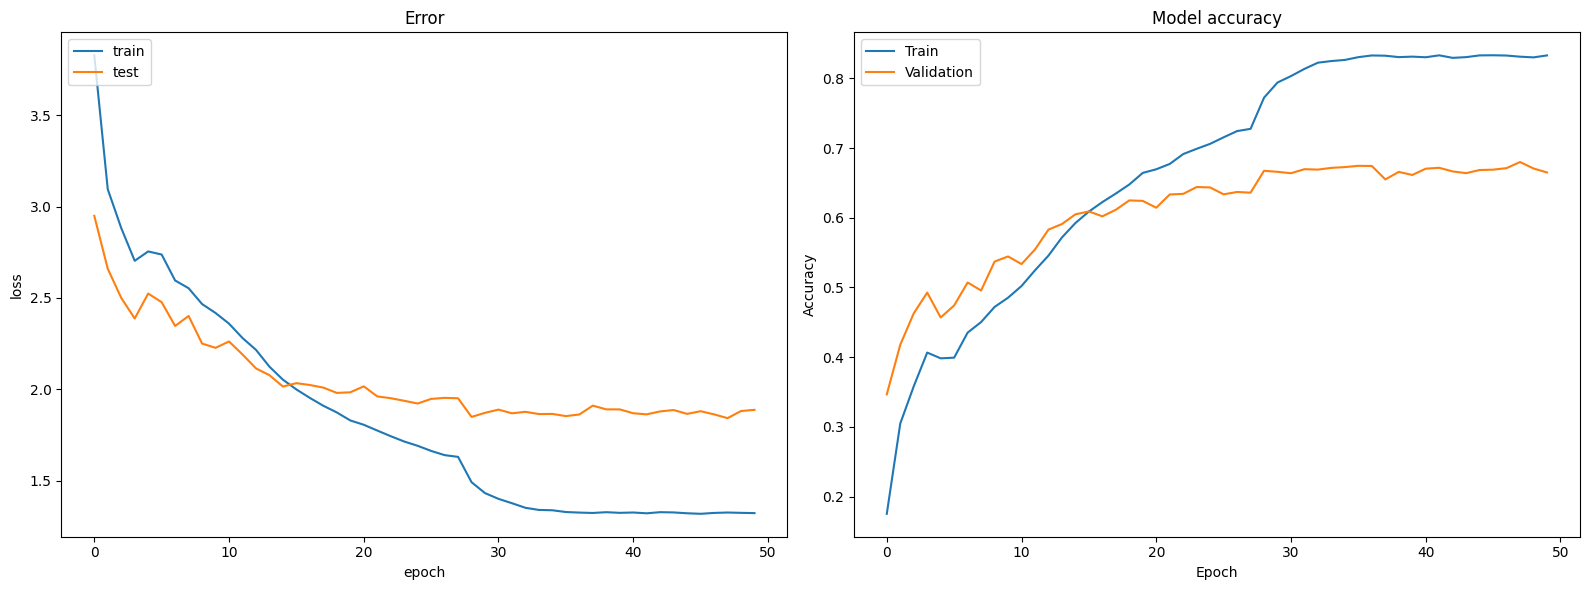

In [11]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_title('Error')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')


ax2.plot(hist.history['accuracy'])
ax2.plot(hist.history['val_accuracy'])
ax2.set_title('Model accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()
